Check cuda version

In [1]:
!/usr/local/cuda/bin/nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Sat_Aug_25_21:08:01_CDT_2018
Cuda compilation tools, release 10.0, V10.0.130


In Linux, the environment variable `LD_LIBRARY_PATH` is a colon-separated set of directories where libraries should be searched for first, before the standard set of directories; this is useful when debugging a new library or using a nonstandard library for special purposes. - [source](https://askubuntu.com/questions/844578/what-does-manpath-ld-library-path-mean-in-linux)

__NOTE__: Run it before launching `jupyter`

In [2]:
!export LD_LIBRARY_PATH=/usr/local/cuda-10.0/lib64

In [3]:
PATH = '.'
PATH_DATA = PATH + r'/data/'
PATH_RUBERT = PATH + r'/ru_bert_tf'
PATH_SAVE = PATH + r'/modelResults'
train_file = r'train_2020_04+.csv'
valid_file = r'validate_2020_04+.csv'
test_file = r'test_2020_04+.csv'
train_file_tr = r'train_2020_04+_tr.csv'
valid_file_tr = r'validate_2020_04+_tr.csv'
test_file_tr = r'test_2020_04+_tr.csv'

In [4]:
!ls $PATH_RUBERT

bert_config.json		     bert_model.ckpt.index
bert_model.ckpt.data-00000-of-00001  vocab.txt


Clear the GPU if needed

In [5]:
!nvidia-smi

Wed Feb 17 07:51:26 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.87.01    Driver Version: 418.87.01    CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:00:1E.0 Off |                    0 |
| N/A   30C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [6]:
from numba import cuda 

device = cuda.get_current_device()
device.reset()

In [7]:
!nvidia-smi

Wed Feb 17 07:51:29 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.87.01    Driver Version: 418.87.01    CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:00:1E.0 Off |                    0 |
| N/A   31C    P0    26W /  70W |     10MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

Test for GPU availability

In [8]:
import tensorflow as tf

tf.test.is_built_with_cuda()
tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None)

True

In [9]:
from deeppavlov.dataset_readers.basic_classification_reader import BasicClassificationDatasetReader
from deeppavlov.dataset_iterators.basic_classification_iterator import BasicClassificationDatasetIterator

from deeppavlov.core.data.simple_vocab import SimpleVocabulary

from deeppavlov.models.preprocessors.bert_preprocessor import BertPreprocessor
from deeppavlov.models.preprocessors.one_hotter import OneHotter
from deeppavlov.models.bert.bert_classifier import BertClassifierModel

from deeppavlov.metrics.roc_auc_score import roc_auc_score
from deeppavlov.metrics.fmeasure import round_f1_weighted
from deeppavlov.metrics.accuracy import sets_accuracy

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import f1_score, hamming_loss, accuracy_score, \
    roc_auc_score, roc_curve, multilabel_confusion_matrix, confusion_matrix

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import datetime
import time
import re
import ast

from tqdm import tqdm_notebook

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to
[nltk_data]     /home/a-dbaiturs@PMICLOUD.GLOBAL/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/a-dbaiturs@PMICLOUD.GLOBAL/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package perluniprops to
[nltk_data]     /home/a-dbaiturs@PMICLOUD.GLOBAL/nltk_data...
[nltk_data]   Package perluniprops is already up-to-date!
[nltk_data] Downloading package nonbreaking_prefixes to
[nltk_data]     /home/a-dbaiturs@PMICLOUD.GLOBAL/nltk_data...
[nltk_data]   Package nonbreaking_prefixes is already up-to-date!


# Data transformation

Removing (negative/positive) labels from target variable

In [10]:
df_train = pd.read_csv(PATH_DATA + train_file_tr)
df_train.sample(10)

,comment,topicsRaw,topics
24280,"Комфортно использовать, частота курения ниже ч...",['Alternative to cigarette'],Alternative to cigarette
64160,"Сломалось зарядное устройство,сразу дали новое...","['Charger, holder or accessories reliability',...","Charger, holder or accessories reliability;Ret..."
65459,"Если курить, то iqos.10",['Alternative to cigarette'],Alternative to cigarette
38124,"Удобно, комфортно, безопасно.??",['Uncategorized'],Uncategorized
28109,"Курьер вежлив, доставка быстра","['Friendliness', 'Order & delivery details acc...",Friendliness;Order & delivery details accuracy
35876,Хорошая вещь10,['Uncategorized'],Uncategorized
2480,Удобно,['Uncategorized'],Uncategorized
3038,"Очень понравился менеджер Артём, всё подробно ...",['Staff reliability'],Staff reliability
49894,Не надежность держателей.,"['Charger, holder or accessories reliability']","Charger, holder or accessories reliability"
66821,"Не могу связаться с менеджером, сломан, горит ...","['Charger, holder or accessories reliability',...","Charger, holder or accessories reliability;Ser..."


In [11]:
!head -20 $PATH_DATA$train_file

hash_message_id,0,id,clr_comment,en_comment,x
ca1252bac15399fb54dfad51e1ab8365a68ed288,['Uncategorized (positive)'],ca1252bac15399fb54dfad51e1ab8365a68ed288,"Удобно, практично10","Convenient, practical10",Uncategorized (positive)
45e64cd718fbb7fc7ae2e45d9685bc0b22999006,['Uncategorized (positive)'],45e64cd718fbb7fc7ae2e45d9685bc0b22999006,Лучше сигареты,Better cigarettes,Uncategorized (positive)
21ed433622b89d68d50fb8f16d14db2ce3492fe1,['Staff reliability (negative)'],21ed433622b89d68d50fb8f16d14db2ce3492fe1,Операторы долго не понимали что я хочу от них,Operators didn't understand for a long time what I wanted from them,Staff reliability (negative)
d514896e7260162cbaaebb08d381b1ce0a494652,['Uncategorized (positive)'],d514896e7260162cbaaebb08d381b1ce0a494652,В токих случаях я никому ничего не рекомендую,I don't recommend anything to anyone.,Uncategorized (positive)
b8dd9ae1c211b8d7223159aa4bf4ba71b4809c40,['Smoke & smell (positive)'],b8dd9ae1c211b8d7223159aa4bf4ba71b4809c40,"Удобство, н

In [12]:
!head -20 $PATH_DATA$train_file_tr

comment,topicsRaw,topics
"Удобно, практично10",['Uncategorized'],Uncategorized
Лучше сигареты,['Uncategorized'],Uncategorized
Операторы долго не понимали что я хочу от них,['Staff reliability'],Staff reliability
В токих случаях я никому ничего не рекомендую,['Uncategorized'],Uncategorized
"Удобство, нет запаха",['Smoke & smell'],Smoke & smell
"Грамотно все объяснили и посоветовали то,что мне нужно !",['Expertise'],Expertise
Обязательно порекомендую,['Uncategorized'],Uncategorized
Он лучше,['Uncategorized'],Uncategorized
Меня устрвиарет,['Uncategorized'],Uncategorized
"Удобно ,меньше вреда здоровью",['Alternative to cigarette'],Alternative to cigarette
Всё нравится !,['Uncategorized'],Uncategorized
"Очень хорошее обслуживание, отзывчивые сотрудники в магазине",['Staff reliability'],Staff reliability
Хороший сервис,['Staff reliability'],Staff reliability
По моим рекомендациям много друзей перешли на IQOS. Мне нравится),['Social inclusion'],Social inclusion
"Качественное обслуживание, веж

# Model description

* Model itself is BERT classifier - [`BertClassifierModel`](http://docs.deeppavlov.ai/en/master/apiref/models/bert.html#deeppavlov.models.bert.bert_classifier.BertClassifierModel) from DeepPavlov
* Optimizer is set to be [`AdamWeightDecayOptimizer`](https://github.com/google-research/bert/blob/eedf5716ce1268e56f0a50264a88cafad334ac61/optimization.py#L87) from Google Research
* As a preprocessor for our inputs, we shall be using BERT trained on russian language - [__Conversational RuBERT__](http://docs.deeppavlov.ai/en/master/features/models/bert.html) from DeepPavlov
* As a vocabulary for target classes we shall use [`SimpleVocabulary`](http://docs.deeppavlov.ai/en/master/_modules/deeppavlov/core/data/simple_vocab.html) from DeepPavlov
* As a probability to labels processing method we shall use [`prob2labels`](http://docs.deeppavlov.ai/en/master/_modules/deeppavlov/models/classifiers/proba2labels.html) from DeepPavlov
* As a one hot encoder for target variable we shall use [`OneHotter`](https://docs.deeppavlov.ai/en/0.0.6.5/_modules/deeppavlov/models/preprocessors/one_hotter.html) from DeepPavlov
* As metrics we will use `sklearn.metrics`
* As additional metrics we can use following from DeepPavlov:
  * Accuracy measure - [`sets_accuracy`](http://docs.deeppavlov.ai/en/master/apiref/metrics.html#deeppavlov.metrics.accuracy.sets_accuracy)
  * F1 score - [`round_f1_weighted`](http://docs.deeppavlov.ai/en/master/apiref/metrics.html#deeppavlov.metrics.fmeasure.round_f1)
  * AUC score - [`roc_auc_score`](http://docs.deeppavlov.ai/en/master/apiref/metrics.html#deeppavlov.metrics.roc_auc_score.roc_auc_score)
  
# Train
## Model definition
### Run following cell if you didn't train your model

In [13]:
modelName, vocabName = (r'/model_140221', r'/vocab_140221')

reader = BasicClassificationDatasetReader()
data = reader.read(
    data_path = PATH_DATA, train = train_file_tr, valid = valid_file_tr,
    test = test_file_tr, class_sep =';', x = 'comment', y = 'topics'
)

iterator = BasicClassificationDatasetIterator(data, shuffle = True)
vocab = SimpleVocabulary(save_path = PATH_SAVE + vocabName)

vocab.fit(iterator.get_instances(data_type="train")[1])
vocab.save()

one_hotter = OneHotter(
    depth=vocab.len, 
    single_vector=True)

bert_preprocessor = BertPreprocessor(
    vocab_file=PATH_RUBERT + r'/vocab.txt',
    do_lower_case=False,
    max_seq_length=64
)

bert_classifier = BertClassifierModel(
    n_classes = vocab.len,
    return_probas = True,
    one_hot_labels = True,
    bert_config_file = PATH_RUBERT + r'/bert_config.json',
    pretrained_bert = r'bert_model.ckpt',
    save_path = PATH_SAVE + modelName,
    load_path = PATH_SAVE + modelName,
    keep_prob = 0.5,
    learning_rate = 1e-05,
    min_learning_rate = 1e-07,
    learning_rate_drop_patience = 5,
    learning_rate_drop_div = 2.0,
    multilabel = True
)

2021-02-13 19:43:33.665 WARNING in 'deeppavlov.core.models.serializable'['serializable'] at line 49: No load path is set for SimpleVocabulary in 'infer' mode. Using save path instead
2021-02-13 19:43:33.666 INFO in 'deeppavlov.core.data.simple_vocab'['simple_vocab'] at line 115: [loading vocabulary from /home/a-dbaiturs@PMICLOUD.GLOBAL/Projects/Project1/bertNewModel/results/vocab_140221]
2021-02-13 19:43:34.244 INFO in 'deeppavlov.core.data.simple_vocab'['simple_vocab'] at line 101: [saving vocabulary to /home/a-dbaiturs@PMICLOUD.GLOBAL/Projects/Project1/bertNewModel/results/vocab_140221]









The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




Instructions for updating:
Use standard file APIs to check for files with this prefix.


2021-02-13 19:43:51.215 INFO in 'deeppavlov.core.models.tf_model'['tf_model'] at line 51: [loading model from /home/a-dbaiturs@PMICLOUD.GLOBAL/Projects/Project1/bertNewModel/results/model_140221]



INFO:tensorflow:Restoring parameters from /home/a-dbaiturs@PMICLOUD.GLOBAL/Projects/Project1/bertNewModel/results/model_140221


In [14]:
!nvidia-smi

Sat Feb 13 19:43:52 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.87.01    Driver Version: 418.87.01    CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:00:1E.0 Off |                    0 |
| N/A   54C    P0    33W /  70W |  14453MiB / 15079MiB |     49%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

### Run following cell if you want to continue training

In [ ]:
modelName, vocabName = (r'/model_140221', r'/vocab_140221')

reader = BasicClassificationDatasetReader()
data = reader.read(
    data_path = PATH_DATA, train = train_file_tr, valid = valid_file_tr,
    test = test_file_tr, class_sep =';', x = 'comment', y = 'topics'
)

iterator = BasicClassificationDatasetIterator(data, shuffle = True)
vocab = SimpleVocabulary(save_path = PATH_SAVE + vocabName)
vocab.load()

one_hotter = OneHotter(
    depth=vocab.len, 
    single_vector=True)

bert_preprocessor = BertPreprocessor(
    vocab_file=PATH_RUBERT + r'/vocab.txt',
    do_lower_case=False,
    max_seq_length=64
)

bert_classifier = BertClassifierModel(
    n_classes = vocab.len,
    return_probas = True,
    one_hot_labels = True,
    bert_config_file = PATH_RUBERT + r'/bert_config.json',
    pretrained_bert = r'bert_model.ckpt',
    save_path = PATH_SAVE + modelName,
    load_path = PATH_SAVE + modelName,
    keep_prob = 0.5,
    learning_rate = 1e-05,
    min_learning_rate = 1e-07,
    learning_rate_drop_patience = 5,
    learning_rate_drop_div = 2.0,
    multilabel = True
)
bert_classifier.load()

NameError: ignored

### Helper functions

In [13]:
def calculate_metrics(y_true, predictions, num_classes, micro = False, ts = None):
    if ts is None:
        y_pred = (predictions>0.5).astype(int)
    else:
        y_pred = (predictions>ts).astype(int)
        
    check =  ((y_pred.sum(axis=0) > 0).sum() == y_pred.shape[1]) | ((y_pred.sum(axis=0) > 0).sum() == 0)
    acc_total = 0.0 if check else \
        accuracy_score(y_true[:, 
                              (y_pred.sum(axis=0) != y_true.shape[0]) &
                              (y_pred.sum(axis=0) > 0)], 
                       y_pred[:, 
                              (y_pred.sum(axis=0) != y_true.shape[0]) &
                              (y_pred.sum(axis=0) > 0)])
    hamm_loss = hamming_loss(y_true, y_pred)
    f1_score_total = f1_score(y_true[:, y_true.sum(axis=0) > 0], 
                              y_pred[:, y_true.sum(axis=0) > 0], 
                              average='weighted')
    roc_auc_total = roc_auc_score(y_true[:, y_true.sum(axis=0) > 0],
                                  predictions[:, y_true.sum(axis=0) > 0], 
                                  average='weighted')

    
    acc_classes = None
    f1_scores_classes = None
    roc_auc_classes = None

    if micro:
        acc_classes = []
        f1_scores_classes = []
        roc_auc_classes = []

        for i in range(num_classes):
            acc_class = accuracy_score(y_true[:, i], y_pred[:, i])
            acc_classes.append(acc_class)
            f1_score_class = np.NAN if y_true[:, i].sum() == 0 else\
                f1_score(y_true[:, i], y_pred[:, i], average='macro')
            f1_scores_classes.append(f1_score_class)
            roc_auc_class = np.NAN if y_true[:, i].sum() == 0 else\
                roc_auc_score(y_true[:, i], predictions[:, i], average='macro')
            roc_auc_classes.append(roc_auc_class)
    
    return acc_total, acc_classes, hamm_loss, f1_score_total, f1_scores_classes, roc_auc_total, roc_auc_classes

def optimal_threshold(y_true, predictions, num_classes, verbose = False):
    thresholds = np.linspace(0,1,10000)
    
    # False negative rate
    fnr = np.zeros((num_classes, 10000))
    
    # False discovery rate
    fdr = np.zeros((num_classes, 10000))
    
    if verbose:
        print('Calculating optimal threshold')
        for i, threshold in enumerate(tqdm_notebook(thresholds)):
            tp = ((y_true == 1) & (predictions > threshold)).sum(axis=0)
            fn = ((y_true == 1) & (predictions <= threshold)).sum(axis=0)
            fp = ((y_true == 0) & (predictions > threshold)).sum(axis=0)
            fnr[:, i] = fn/(tp + fn)
            fdr[:, i] = fp/(tp + fp)
    else:
        for i, threshold in enumerate(thresholds):
            tp = ((y_true == 1) & (predictions > threshold)).sum(axis=0)
            fn = ((y_true == 1) & (predictions <= threshold)).sum(axis=0)
            fp = ((y_true == 0) & (predictions > threshold)).sum(axis=0)
            fnr[:, i] = fn/(tp + fn)
            fdr[:, i] = fp/(tp + fp)

    return thresholds[np.abs(fnr-fdr).argsort(axis=1)[:, 0]]

def get_preds(data_type, verbose = False, mlb = None):
    y_preds = []
    
    data = iterator.get_instances(data_type)
    
    if verbose:
        print(f'Predicting {data_type} data')
        for i in tqdm_notebook(range(0, len(data[0]), 256)):
            x = data[0][i:i + 256]

            y_pred = bert_classifier(bert_preprocessor(x))
            y_preds.append(y_pred)
    else:
        for i in range(0, len(data[0]), 256):
            x = data[0][i:i + 256]

            y_pred = bert_classifier(bert_preprocessor(x))
            y_preds.append(y_pred)
        
    y_preds = np.concatenate(y_preds, axis=0)
    y_true = data[1]

    if mlb is None:
        categories, _ = zip(*vocab.items())
        mlb = MultiLabelBinarizer(classes=categories)
        y_true = mlb.fit_transform(y_true)
    else:
        y_true = mlb.transform(y_true)
    
    return  y_true, y_preds, mlb

### Training
#### Batch size

>The presented results confirm that using small batch sizes achieves the best training stability and
generalization performance, for a given computational cost, across a wide range of experiments. In
all cases the best results have been obtained with batch sizes m = 32 or smaller, often as small as
m = 2 or m = 4. - [source](https://arxiv.org/pdf/1804.07612.pdf)



In [16]:
best_score = 0.1
patience = 10
impatience = 0

print(datetime.datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d %H:%M:%S')+" Training started")

for ep in range(300):
    nbatches = 0
    for x, y in iterator.gen_batches(batch_size=32, 
                                     data_type="train", shuffle=True):
        x_feat = bert_preprocessor(x)
        y_onehot = one_hotter(vocab(y))
        bert_classifier.train_on_batch(x_feat, y_onehot)
        nbatches += 1
        
        if nbatches % 200 == 0:
            y_true, y_preds, mlb = get_preds('valid')
            acc, _, hamm, f1, _, roc_auc, _ = \
                calculate_metrics(y_true, y_preds, len(mlb.classes_))
            print(datetime.datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d %H:%M:%S')+ \
                  f" Batches done: {nbatches}.Validaiton accuracy: {acc:.5f}, F1 score: {f1:.5f}, hamming loss
                  {hamm:.5f}, ROC-AUC: {roc_auc:.5f}")
            if f1 > best_score:
                bert_classifier.save()
                print("New best F1 score. Saving model.")
                best_score = f1    
                impatience = 0            
            
    
    print(f"Epochs done: {ep+1}")
    impatience += 1
    if impatience == patience:
        print("Out of patience. Stop training.")
        break

2021-02-13 19:44:21 Training started


2021-02-13 19:46:43.615 INFO in 'deeppavlov.core.models.tf_model'['tf_model'] at line 75: [saving model to /home/a-dbaiturs@PMICLOUD.GLOBAL/Projects/Project1/bertNewModel/results/model_140221]


2021-02-13 19:46:43 Batches done: 200.Validaiton accuracy: 0.81961, F1 score: 0.28584, hamming Loss: 0.02337, ROC-AUC: 0.84858
New best F1 score. Saving model.


2021-02-13 19:49:04.311 INFO in 'deeppavlov.core.models.tf_model'['tf_model'] at line 75: [saving model to /home/a-dbaiturs@PMICLOUD.GLOBAL/Projects/Project1/bertNewModel/results/model_140221]


2021-02-13 19:49:04 Batches done: 400.Validaiton accuracy: 0.57881, F1 score: 0.50314, hamming Loss: 0.02021, ROC-AUC: 0.89342
New best F1 score. Saving model.


2021-02-13 19:51:27.664 INFO in 'deeppavlov.core.models.tf_model'['tf_model'] at line 75: [saving model to /home/a-dbaiturs@PMICLOUD.GLOBAL/Projects/Project1/bertNewModel/results/model_140221]


2021-02-13 19:51:27 Batches done: 600.Validaiton accuracy: 0.63850, F1 score: 0.52936, hamming Loss: 0.01839, ROC-AUC: 0.92037
New best F1 score. Saving model.


2021-02-13 19:53:50.775 INFO in 'deeppavlov.core.models.tf_model'['tf_model'] at line 75: [saving model to /home/a-dbaiturs@PMICLOUD.GLOBAL/Projects/Project1/bertNewModel/results/model_140221]


2021-02-13 19:53:50 Batches done: 800.Validaiton accuracy: 0.67265, F1 score: 0.53879, hamming Loss: 0.01778, ROC-AUC: 0.92563
New best F1 score. Saving model.


2021-02-13 19:56:13.984 INFO in 'deeppavlov.core.models.tf_model'['tf_model'] at line 75: [saving model to /home/a-dbaiturs@PMICLOUD.GLOBAL/Projects/Project1/bertNewModel/results/model_140221]


2021-02-13 19:56:13 Batches done: 1000.Validaiton accuracy: 0.70290, F1 score: 0.59482, hamming Loss: 0.01652, ROC-AUC: 0.93320
New best F1 score. Saving model.
2021-02-13 19:58:37 Batches done: 1200.Validaiton accuracy: 0.72854, F1 score: 0.59466, hamming Loss: 0.01594, ROC-AUC: 0.93971


2021-02-13 20:00:58.381 INFO in 'deeppavlov.core.models.tf_model'['tf_model'] at line 75: [saving model to /home/a-dbaiturs@PMICLOUD.GLOBAL/Projects/Project1/bertNewModel/results/model_140221]


2021-02-13 20:00:58 Batches done: 1400.Validaiton accuracy: 0.75069, F1 score: 0.60712, hamming Loss: 0.01538, ROC-AUC: 0.94437
New best F1 score. Saving model.


2021-02-13 20:03:21.823 INFO in 'deeppavlov.core.models.tf_model'['tf_model'] at line 75: [saving model to /home/a-dbaiturs@PMICLOUD.GLOBAL/Projects/Project1/bertNewModel/results/model_140221]


2021-02-13 20:03:21 Batches done: 1600.Validaiton accuracy: 0.71541, F1 score: 0.61291, hamming Loss: 0.01518, ROC-AUC: 0.94658
New best F1 score. Saving model.


2021-02-13 20:05:45.251 INFO in 'deeppavlov.core.models.tf_model'['tf_model'] at line 75: [saving model to /home/a-dbaiturs@PMICLOUD.GLOBAL/Projects/Project1/bertNewModel/results/model_140221]


2021-02-13 20:05:45 Batches done: 1800.Validaiton accuracy: 0.69377, F1 score: 0.61937, hamming Loss: 0.01513, ROC-AUC: 0.95010
New best F1 score. Saving model.


2021-02-13 20:08:08.663 INFO in 'deeppavlov.core.models.tf_model'['tf_model'] at line 75: [saving model to /home/a-dbaiturs@PMICLOUD.GLOBAL/Projects/Project1/bertNewModel/results/model_140221]


2021-02-13 20:08:08 Batches done: 2000.Validaiton accuracy: 0.67521, F1 score: 0.63051, hamming Loss: 0.01480, ROC-AUC: 0.95154
New best F1 score. Saving model.
2021-02-13 20:10:31 Batches done: 2200.Validaiton accuracy: 0.72536, F1 score: 0.62433, hamming Loss: 0.01480, ROC-AUC: 0.95255


2021-02-13 20:12:52.803 INFO in 'deeppavlov.core.models.tf_model'['tf_model'] at line 75: [saving model to /home/a-dbaiturs@PMICLOUD.GLOBAL/Projects/Project1/bertNewModel/results/model_140221]


2021-02-13 20:12:52 Batches done: 2400.Validaiton accuracy: 0.64988, F1 score: 0.65821, hamming Loss: 0.01424, ROC-AUC: 0.95492
New best F1 score. Saving model.


2021-02-13 20:15:16.46 INFO in 'deeppavlov.core.models.tf_model'['tf_model'] at line 75: [saving model to /home/a-dbaiturs@PMICLOUD.GLOBAL/Projects/Project1/bertNewModel/results/model_140221]


2021-02-13 20:15:16 Batches done: 2600.Validaiton accuracy: 0.67542, F1 score: 0.66864, hamming Loss: 0.01394, ROC-AUC: 0.95568
New best F1 score. Saving model.
Epochs done: {}
2021-02-13 20:18:49 Batches done: 200.Validaiton accuracy: 0.69531, F1 score: 0.66178, hamming Loss: 0.01389, ROC-AUC: 0.95860


2021-02-13 20:21:10.62 INFO in 'deeppavlov.core.models.tf_model'['tf_model'] at line 75: [saving model to /home/a-dbaiturs@PMICLOUD.GLOBAL/Projects/Project1/bertNewModel/results/model_140221]


2021-02-13 20:21:10 Batches done: 400.Validaiton accuracy: 0.68649, F1 score: 0.67590, hamming Loss: 0.01344, ROC-AUC: 0.95995
New best F1 score. Saving model.


2021-02-13 20:23:33.404 INFO in 'deeppavlov.core.models.tf_model'['tf_model'] at line 75: [saving model to /home/a-dbaiturs@PMICLOUD.GLOBAL/Projects/Project1/bertNewModel/results/model_140221]


2021-02-13 20:23:33 Batches done: 600.Validaiton accuracy: 0.69039, F1 score: 0.69970, hamming Loss: 0.01305, ROC-AUC: 0.95976
New best F1 score. Saving model.


2021-02-13 20:25:56.749 INFO in 'deeppavlov.core.models.tf_model'['tf_model'] at line 75: [saving model to /home/a-dbaiturs@PMICLOUD.GLOBAL/Projects/Project1/bertNewModel/results/model_140221]


2021-02-13 20:25:56 Batches done: 800.Validaiton accuracy: 0.67132, F1 score: 0.71829, hamming Loss: 0.01259, ROC-AUC: 0.96131
New best F1 score. Saving model.
2021-02-13 20:28:20 Batches done: 1000.Validaiton accuracy: 0.67706, F1 score: 0.71303, hamming Loss: 0.01270, ROC-AUC: 0.96252


2021-02-13 20:30:41.415 INFO in 'deeppavlov.core.models.tf_model'['tf_model'] at line 75: [saving model to /home/a-dbaiturs@PMICLOUD.GLOBAL/Projects/Project1/bertNewModel/results/model_140221]


2021-02-13 20:30:41 Batches done: 1200.Validaiton accuracy: 0.68167, F1 score: 0.72424, hamming Loss: 0.01235, ROC-AUC: 0.96302
New best F1 score. Saving model.


2021-02-13 20:33:04.837 INFO in 'deeppavlov.core.models.tf_model'['tf_model'] at line 75: [saving model to /home/a-dbaiturs@PMICLOUD.GLOBAL/Projects/Project1/bertNewModel/results/model_140221]


2021-02-13 20:33:04 Batches done: 1400.Validaiton accuracy: 0.68947, F1 score: 0.72620, hamming Loss: 0.01224, ROC-AUC: 0.96491
New best F1 score. Saving model.


2021-02-13 20:35:28.326 INFO in 'deeppavlov.core.models.tf_model'['tf_model'] at line 75: [saving model to /home/a-dbaiturs@PMICLOUD.GLOBAL/Projects/Project1/bertNewModel/results/model_140221]


2021-02-13 20:35:28 Batches done: 1600.Validaiton accuracy: 0.68967, F1 score: 0.74774, hamming Loss: 0.01188, ROC-AUC: 0.96493
New best F1 score. Saving model.
2021-02-13 20:37:51 Batches done: 1800.Validaiton accuracy: 0.69234, F1 score: 0.73566, hamming Loss: 0.01206, ROC-AUC: 0.96510


2021-02-13 20:40:12.881 INFO in 'deeppavlov.core.models.tf_model'['tf_model'] at line 75: [saving model to /home/a-dbaiturs@PMICLOUD.GLOBAL/Projects/Project1/bertNewModel/results/model_140221]


2021-02-13 20:40:12 Batches done: 2000.Validaiton accuracy: 0.68772, F1 score: 0.74892, hamming Loss: 0.01174, ROC-AUC: 0.96669
New best F1 score. Saving model.
2021-02-13 20:42:36 Batches done: 2200.Validaiton accuracy: 0.70352, F1 score: 0.73955, hamming Loss: 0.01193, ROC-AUC: 0.96621


2021-02-13 20:44:57.478 INFO in 'deeppavlov.core.models.tf_model'['tf_model'] at line 75: [saving model to /home/a-dbaiturs@PMICLOUD.GLOBAL/Projects/Project1/bertNewModel/results/model_140221]


2021-02-13 20:44:57 Batches done: 2400.Validaiton accuracy: 0.69542, F1 score: 0.74950, hamming Loss: 0.01179, ROC-AUC: 0.96814
New best F1 score. Saving model.


2021-02-13 20:47:21.32 INFO in 'deeppavlov.core.models.tf_model'['tf_model'] at line 75: [saving model to /home/a-dbaiturs@PMICLOUD.GLOBAL/Projects/Project1/bertNewModel/results/model_140221]


2021-02-13 20:47:21 Batches done: 2600.Validaiton accuracy: 0.69316, F1 score: 0.75018, hamming Loss: 0.01154, ROC-AUC: 0.96821
New best F1 score. Saving model.
Epochs done: {}


2021-02-13 20:50:54.549 INFO in 'deeppavlov.core.models.tf_model'['tf_model'] at line 75: [saving model to /home/a-dbaiturs@PMICLOUD.GLOBAL/Projects/Project1/bertNewModel/results/model_140221]


2021-02-13 20:50:54 Batches done: 200.Validaiton accuracy: 0.67573, F1 score: 0.76725, hamming Loss: 0.01133, ROC-AUC: 0.96906
New best F1 score. Saving model.
2021-02-13 20:53:18 Batches done: 400.Validaiton accuracy: 0.68301, F1 score: 0.76627, hamming Loss: 0.01126, ROC-AUC: 0.96905
2021-02-13 20:55:39 Batches done: 600.Validaiton accuracy: 0.68988, F1 score: 0.75472, hamming Loss: 0.01141, ROC-AUC: 0.96963


2021-02-13 20:58:00.199 INFO in 'deeppavlov.core.models.tf_model'['tf_model'] at line 75: [saving model to /home/a-dbaiturs@PMICLOUD.GLOBAL/Projects/Project1/bertNewModel/results/model_140221]


2021-02-13 20:58:00 Batches done: 800.Validaiton accuracy: 0.67983, F1 score: 0.77275, hamming Loss: 0.01124, ROC-AUC: 0.97070
New best F1 score. Saving model.
2021-02-13 21:00:23 Batches done: 1000.Validaiton accuracy: 0.69224, F1 score: 0.76129, hamming Loss: 0.01125, ROC-AUC: 0.96917
2021-02-13 21:02:44 Batches done: 1200.Validaiton accuracy: 0.67419, F1 score: 0.76239, hamming Loss: 0.01147, ROC-AUC: 0.97014


2021-02-13 21:05:05.757 INFO in 'deeppavlov.core.models.tf_model'['tf_model'] at line 75: [saving model to /home/a-dbaiturs@PMICLOUD.GLOBAL/Projects/Project1/bertNewModel/results/model_140221]


2021-02-13 21:05:05 Batches done: 1400.Validaiton accuracy: 0.68752, F1 score: 0.78112, hamming Loss: 0.01102, ROC-AUC: 0.97112
New best F1 score. Saving model.
2021-02-13 21:07:29 Batches done: 1600.Validaiton accuracy: 0.66998, F1 score: 0.77635, hamming Loss: 0.01142, ROC-AUC: 0.97069


2021-02-13 21:09:50.697 INFO in 'deeppavlov.core.models.tf_model'['tf_model'] at line 75: [saving model to /home/a-dbaiturs@PMICLOUD.GLOBAL/Projects/Project1/bertNewModel/results/model_140221]


2021-02-13 21:09:50 Batches done: 1800.Validaiton accuracy: 0.69111, F1 score: 0.78304, hamming Loss: 0.01100, ROC-AUC: 0.97102
New best F1 score. Saving model.
2021-02-13 21:12:14 Batches done: 2000.Validaiton accuracy: 0.68167, F1 score: 0.77712, hamming Loss: 0.01094, ROC-AUC: 0.97227
2021-02-13 21:14:35 Batches done: 2200.Validaiton accuracy: 0.69357, F1 score: 0.77652, hamming Loss: 0.01095, ROC-AUC: 0.97155


2021-02-13 21:16:56.342 INFO in 'deeppavlov.core.models.tf_model'['tf_model'] at line 75: [saving model to /home/a-dbaiturs@PMICLOUD.GLOBAL/Projects/Project1/bertNewModel/results/model_140221]


2021-02-13 21:16:56 Batches done: 2400.Validaiton accuracy: 0.68978, F1 score: 0.78490, hamming Loss: 0.01097, ROC-AUC: 0.97198
New best F1 score. Saving model.


2021-02-13 21:19:20.19 INFO in 'deeppavlov.core.models.tf_model'['tf_model'] at line 75: [saving model to /home/a-dbaiturs@PMICLOUD.GLOBAL/Projects/Project1/bertNewModel/results/model_140221]


2021-02-13 21:19:20 Batches done: 2600.Validaiton accuracy: 0.69439, F1 score: 0.78621, hamming Loss: 0.01092, ROC-AUC: 0.97230
New best F1 score. Saving model.
Epochs done: {}


2021-02-13 21:22:53.497 INFO in 'deeppavlov.core.models.tf_model'['tf_model'] at line 75: [saving model to /home/a-dbaiturs@PMICLOUD.GLOBAL/Projects/Project1/bertNewModel/results/model_140221]


2021-02-13 21:22:53 Batches done: 200.Validaiton accuracy: 0.70157, F1 score: 0.79137, hamming Loss: 0.01063, ROC-AUC: 0.97308
New best F1 score. Saving model.


2021-02-13 21:25:17.259 INFO in 'deeppavlov.core.models.tf_model'['tf_model'] at line 75: [saving model to /home/a-dbaiturs@PMICLOUD.GLOBAL/Projects/Project1/bertNewModel/results/model_140221]


2021-02-13 21:25:17 Batches done: 400.Validaiton accuracy: 0.68875, F1 score: 0.79303, hamming Loss: 0.01112, ROC-AUC: 0.97328
New best F1 score. Saving model.


2021-02-13 21:27:41.116 INFO in 'deeppavlov.core.models.tf_model'['tf_model'] at line 75: [saving model to /home/a-dbaiturs@PMICLOUD.GLOBAL/Projects/Project1/bertNewModel/results/model_140221]


2021-02-13 21:27:41 Batches done: 600.Validaiton accuracy: 0.70588, F1 score: 0.80254, hamming Loss: 0.01040, ROC-AUC: 0.97338
New best F1 score. Saving model.
2021-02-13 21:30:05 Batches done: 800.Validaiton accuracy: 0.69983, F1 score: 0.79419, hamming Loss: 0.01063, ROC-AUC: 0.97344
2021-02-13 21:32:26 Batches done: 1000.Validaiton accuracy: 0.70598, F1 score: 0.79949, hamming Loss: 0.01051, ROC-AUC: 0.97358
2021-02-13 21:34:47 Batches done: 1200.Validaiton accuracy: 0.69952, F1 score: 0.79629, hamming Loss: 0.01057, ROC-AUC: 0.97364
2021-02-13 21:37:08 Batches done: 1400.Validaiton accuracy: 0.71193, F1 score: 0.79872, hamming Loss: 0.01041, ROC-AUC: 0.97320
2021-02-13 21:39:29 Batches done: 1600.Validaiton accuracy: 0.69665, F1 score: 0.79547, hamming Loss: 0.01064, ROC-AUC: 0.97390
2021-02-13 21:41:51 Batches done: 1800.Validaiton accuracy: 0.70762, F1 score: 0.79892, hamming Loss: 0.01048, ROC-AUC: 0.97335
2021-02-13 21:44:12 Batches done: 2000.Validaiton accuracy: 0.70495, F1 s

2021-02-13 21:46:33.149 INFO in 'deeppavlov.core.models.tf_model'['tf_model'] at line 75: [saving model to /home/a-dbaiturs@PMICLOUD.GLOBAL/Projects/Project1/bertNewModel/results/model_140221]


2021-02-13 21:46:33 Batches done: 2200.Validaiton accuracy: 0.70639, F1 score: 0.80398, hamming Loss: 0.01056, ROC-AUC: 0.97363
New best F1 score. Saving model.


2021-02-13 21:48:57.245 INFO in 'deeppavlov.core.models.tf_model'['tf_model'] at line 75: [saving model to /home/a-dbaiturs@PMICLOUD.GLOBAL/Projects/Project1/bertNewModel/results/model_140221]


2021-02-13 21:48:57 Batches done: 2400.Validaiton accuracy: 0.71152, F1 score: 0.80773, hamming Loss: 0.01027, ROC-AUC: 0.97473
New best F1 score. Saving model.
2021-02-13 21:51:21 Batches done: 2600.Validaiton accuracy: 0.71049, F1 score: 0.80261, hamming Loss: 0.01041, ROC-AUC: 0.97415
Epochs done: {}
2021-02-13 21:54:51 Batches done: 200.Validaiton accuracy: 0.71295, F1 score: 0.79967, hamming Loss: 0.01029, ROC-AUC: 0.97419
2021-02-13 21:57:12 Batches done: 400.Validaiton accuracy: 0.71326, F1 score: 0.80773, hamming Loss: 0.01025, ROC-AUC: 0.97498


2021-02-13 21:59:33.995 INFO in 'deeppavlov.core.models.tf_model'['tf_model'] at line 75: [saving model to /home/a-dbaiturs@PMICLOUD.GLOBAL/Projects/Project1/bertNewModel/results/model_140221]


2021-02-13 21:59:33 Batches done: 600.Validaiton accuracy: 0.71911, F1 score: 0.81142, hamming Loss: 0.01016, ROC-AUC: 0.97395
New best F1 score. Saving model.
2021-02-13 22:01:57 Batches done: 800.Validaiton accuracy: 0.70465, F1 score: 0.80449, hamming Loss: 0.01046, ROC-AUC: 0.97451


2021-02-13 22:04:18.928 INFO in 'deeppavlov.core.models.tf_model'['tf_model'] at line 75: [saving model to /home/a-dbaiturs@PMICLOUD.GLOBAL/Projects/Project1/bertNewModel/results/model_140221]


2021-02-13 22:04:18 Batches done: 1000.Validaiton accuracy: 0.71767, F1 score: 0.81191, hamming Loss: 0.01021, ROC-AUC: 0.97485
New best F1 score. Saving model.
2021-02-13 22:06:42 Batches done: 1200.Validaiton accuracy: 0.70331, F1 score: 0.80372, hamming Loss: 0.01054, ROC-AUC: 0.97451
2021-02-13 22:09:03 Batches done: 1400.Validaiton accuracy: 0.70998, F1 score: 0.80424, hamming Loss: 0.01040, ROC-AUC: 0.97387
2021-02-13 22:11:24 Batches done: 1600.Validaiton accuracy: 0.70803, F1 score: 0.80629, hamming Loss: 0.01046, ROC-AUC: 0.97463
2021-02-13 22:13:45 Batches done: 1800.Validaiton accuracy: 0.70003, F1 score: 0.80176, hamming Loss: 0.01065, ROC-AUC: 0.97446
2021-02-13 22:16:06 Batches done: 2000.Validaiton accuracy: 0.71736, F1 score: 0.81088, hamming Loss: 0.01019, ROC-AUC: 0.97545


2021-02-13 22:18:28.68 INFO in 'deeppavlov.core.models.tf_model'['tf_model'] at line 75: [saving model to /home/a-dbaiturs@PMICLOUD.GLOBAL/Projects/Project1/bertNewModel/results/model_140221]


2021-02-13 22:18:28 Batches done: 2200.Validaiton accuracy: 0.71941, F1 score: 0.81358, hamming Loss: 0.01010, ROC-AUC: 0.97571
New best F1 score. Saving model.
2021-02-13 22:20:52 Batches done: 2400.Validaiton accuracy: 0.72259, F1 score: 0.81008, hamming Loss: 0.01010, ROC-AUC: 0.97510
2021-02-13 22:23:13 Batches done: 2600.Validaiton accuracy: 0.71121, F1 score: 0.81131, hamming Loss: 0.01018, ROC-AUC: 0.97517
Epochs done: {}
2021-02-13 22:26:44 Batches done: 200.Validaiton accuracy: 0.71788, F1 score: 0.81079, hamming Loss: 0.01019, ROC-AUC: 0.97479
2021-02-13 22:29:05 Batches done: 400.Validaiton accuracy: 0.71080, F1 score: 0.80758, hamming Loss: 0.01026, ROC-AUC: 0.97484
2021-02-13 22:31:26 Batches done: 600.Validaiton accuracy: 0.71726, F1 score: 0.80729, hamming Loss: 0.01026, ROC-AUC: 0.97485
2021-02-13 22:33:47 Batches done: 800.Validaiton accuracy: 0.71100, F1 score: 0.81047, hamming Loss: 0.01029, ROC-AUC: 0.97536
2021-02-13 22:36:08 Batches done: 1000.Validaiton accuracy:

2021-02-13 22:40:50.959 INFO in 'deeppavlov.core.models.tf_model'['tf_model'] at line 75: [saving model to /home/a-dbaiturs@PMICLOUD.GLOBAL/Projects/Project1/bertNewModel/results/model_140221]


2021-02-13 22:40:50 Batches done: 1400.Validaiton accuracy: 0.71018, F1 score: 0.81362, hamming Loss: 0.01033, ROC-AUC: 0.97552
New best F1 score. Saving model.
2021-02-13 22:43:14 Batches done: 1600.Validaiton accuracy: 0.71470, F1 score: 0.81212, hamming Loss: 0.01016, ROC-AUC: 0.97506
2021-02-13 22:45:35 Batches done: 1800.Validaiton accuracy: 0.71941, F1 score: 0.81116, hamming Loss: 0.01010, ROC-AUC: 0.97569
2021-02-13 22:47:56 Batches done: 2000.Validaiton accuracy: 0.70290, F1 score: 0.80717, hamming Loss: 0.01070, ROC-AUC: 0.97425


2021-02-13 22:50:17.977 INFO in 'deeppavlov.core.models.tf_model'['tf_model'] at line 75: [saving model to /home/a-dbaiturs@PMICLOUD.GLOBAL/Projects/Project1/bertNewModel/results/model_140221]


2021-02-13 22:50:17 Batches done: 2200.Validaiton accuracy: 0.71264, F1 score: 0.81469, hamming Loss: 0.01024, ROC-AUC: 0.97540
New best F1 score. Saving model.
2021-02-13 22:52:42 Batches done: 2400.Validaiton accuracy: 0.71336, F1 score: 0.81322, hamming Loss: 0.01021, ROC-AUC: 0.97603
2021-02-13 22:55:03 Batches done: 2600.Validaiton accuracy: 0.71029, F1 score: 0.81433, hamming Loss: 0.01022, ROC-AUC: 0.97535
Epochs done: {}
2021-02-13 22:58:34 Batches done: 200.Validaiton accuracy: 0.71470, F1 score: 0.81459, hamming Loss: 0.01017, ROC-AUC: 0.97553
2021-02-13 23:00:55 Batches done: 400.Validaiton accuracy: 0.71613, F1 score: 0.81243, hamming Loss: 0.01016, ROC-AUC: 0.97529
2021-02-13 23:03:16 Batches done: 600.Validaiton accuracy: 0.71018, F1 score: 0.80735, hamming Loss: 0.01032, ROC-AUC: 0.97517
2021-02-13 23:05:37 Batches done: 800.Validaiton accuracy: 0.71941, F1 score: 0.80837, hamming Loss: 0.01020, ROC-AUC: 0.97530
2021-02-13 23:07:59 Batches done: 1000.Validaiton accuracy:

2021-02-13 23:30:19.141 INFO in 'deeppavlov.core.models.tf_model'['tf_model'] at line 75: [saving model to /home/a-dbaiturs@PMICLOUD.GLOBAL/Projects/Project1/bertNewModel/results/model_140221]


2021-02-13 23:30:19 Batches done: 200.Validaiton accuracy: 0.71141, F1 score: 0.81658, hamming Loss: 0.01023, ROC-AUC: 0.97518
New best F1 score. Saving model.
2021-02-13 23:32:43 Batches done: 400.Validaiton accuracy: 0.70700, F1 score: 0.80848, hamming Loss: 0.01051, ROC-AUC: 0.97447
2021-02-13 23:35:04 Batches done: 600.Validaiton accuracy: 0.71429, F1 score: 0.81061, hamming Loss: 0.01028, ROC-AUC: 0.97552
2021-02-13 23:37:25 Batches done: 800.Validaiton accuracy: 0.71090, F1 score: 0.81410, hamming Loss: 0.01035, ROC-AUC: 0.97509
2021-02-13 23:39:46 Batches done: 1000.Validaiton accuracy: 0.71582, F1 score: 0.81425, hamming Loss: 0.01018, ROC-AUC: 0.97546
2021-02-13 23:42:08 Batches done: 1200.Validaiton accuracy: 0.71911, F1 score: 0.81427, hamming Loss: 0.01016, ROC-AUC: 0.97508
2021-02-13 23:44:29 Batches done: 1400.Validaiton accuracy: 0.70249, F1 score: 0.81091, hamming Loss: 0.01057, ROC-AUC: 0.97473
2021-02-13 23:46:50 Batches done: 1600.Validaiton accuracy: 0.71552, F1 sco

2021-02-14 00:02:06.593 INFO in 'deeppavlov.core.models.tf_model'['tf_model'] at line 75: [saving model to /home/a-dbaiturs@PMICLOUD.GLOBAL/Projects/Project1/bertNewModel/results/model_140221]


2021-02-14 00:02:06 Batches done: 200.Validaiton accuracy: 0.71593, F1 score: 0.81717, hamming Loss: 0.01011, ROC-AUC: 0.97497
New best F1 score. Saving model.
2021-02-14 00:04:30 Batches done: 400.Validaiton accuracy: 0.71254, F1 score: 0.81404, hamming Loss: 0.01022, ROC-AUC: 0.97481
2021-02-14 00:06:51 Batches done: 600.Validaiton accuracy: 0.70936, F1 score: 0.81656, hamming Loss: 0.01031, ROC-AUC: 0.97474
2021-02-14 00:09:13 Batches done: 800.Validaiton accuracy: 0.71152, F1 score: 0.81534, hamming Loss: 0.01023, ROC-AUC: 0.97433


2021-02-14 00:11:34.135 INFO in 'deeppavlov.core.models.tf_model'['tf_model'] at line 75: [saving model to /home/a-dbaiturs@PMICLOUD.GLOBAL/Projects/Project1/bertNewModel/results/model_140221]


2021-02-14 00:11:34 Batches done: 1000.Validaiton accuracy: 0.70967, F1 score: 0.81728, hamming Loss: 0.01029, ROC-AUC: 0.97497
New best F1 score. Saving model.
2021-02-14 00:13:58 Batches done: 1200.Validaiton accuracy: 0.71593, F1 score: 0.81435, hamming Loss: 0.01012, ROC-AUC: 0.97477


2021-02-14 00:16:19.294 INFO in 'deeppavlov.core.models.tf_model'['tf_model'] at line 75: [saving model to /home/a-dbaiturs@PMICLOUD.GLOBAL/Projects/Project1/bertNewModel/results/model_140221]


2021-02-14 00:16:19 Batches done: 1400.Validaiton accuracy: 0.71367, F1 score: 0.81733, hamming Loss: 0.01022, ROC-AUC: 0.97406
New best F1 score. Saving model.
2021-02-14 00:18:43 Batches done: 1600.Validaiton accuracy: 0.70495, F1 score: 0.81100, hamming Loss: 0.01041, ROC-AUC: 0.97416
2021-02-14 00:21:04 Batches done: 1800.Validaiton accuracy: 0.71398, F1 score: 0.81569, hamming Loss: 0.01014, ROC-AUC: 0.97469
2021-02-14 00:23:26 Batches done: 2000.Validaiton accuracy: 0.71603, F1 score: 0.81604, hamming Loss: 0.01009, ROC-AUC: 0.97482
2021-02-14 00:25:47 Batches done: 2200.Validaiton accuracy: 0.71090, F1 score: 0.81058, hamming Loss: 0.01036, ROC-AUC: 0.97507
2021-02-14 00:28:08 Batches done: 2400.Validaiton accuracy: 0.71870, F1 score: 0.81723, hamming Loss: 0.01011, ROC-AUC: 0.97482
2021-02-14 00:30:30 Batches done: 2600.Validaiton accuracy: 0.71244, F1 score: 0.81621, hamming Loss: 0.01021, ROC-AUC: 0.97488
Epochs done: {}
2021-02-14 00:34:01 Batches done: 200.Validaiton accura

2021-02-14 00:50:29.597 INFO in 'deeppavlov.core.models.tf_model'['tf_model'] at line 75: [saving model to /home/a-dbaiturs@PMICLOUD.GLOBAL/Projects/Project1/bertNewModel/results/model_140221]


2021-02-14 00:50:29 Batches done: 1600.Validaiton accuracy: 0.71182, F1 score: 0.81941, hamming Loss: 0.01031, ROC-AUC: 0.97349
New best F1 score. Saving model.
2021-02-14 00:52:53 Batches done: 1800.Validaiton accuracy: 0.70793, F1 score: 0.81837, hamming Loss: 0.01036, ROC-AUC: 0.97357
2021-02-14 00:55:15 Batches done: 2000.Validaiton accuracy: 0.70444, F1 score: 0.80998, hamming Loss: 0.01059, ROC-AUC: 0.97318
2021-02-14 00:57:36 Batches done: 2200.Validaiton accuracy: 0.70711, F1 score: 0.81529, hamming Loss: 0.01030, ROC-AUC: 0.97436
2021-02-14 00:59:57 Batches done: 2400.Validaiton accuracy: 0.71121, F1 score: 0.81723, hamming Loss: 0.01023, ROC-AUC: 0.97411


2021-02-14 01:02:18.140 INFO in 'deeppavlov.core.models.tf_model'['tf_model'] at line 75: [saving model to /home/a-dbaiturs@PMICLOUD.GLOBAL/Projects/Project1/bertNewModel/results/model_140221]


2021-02-14 01:02:18 Batches done: 2600.Validaiton accuracy: 0.71613, F1 score: 0.81990, hamming Loss: 0.01014, ROC-AUC: 0.97403
New best F1 score. Saving model.
Epochs done: {}
2021-02-14 01:05:52 Batches done: 200.Validaiton accuracy: 0.70772, F1 score: 0.81714, hamming Loss: 0.01038, ROC-AUC: 0.97335
2021-02-14 01:08:13 Batches done: 400.Validaiton accuracy: 0.70977, F1 score: 0.81701, hamming Loss: 0.01037, ROC-AUC: 0.97338
2021-02-14 01:10:34 Batches done: 600.Validaiton accuracy: 0.70906, F1 score: 0.81793, hamming Loss: 0.01034, ROC-AUC: 0.97338
2021-02-14 01:12:55 Batches done: 800.Validaiton accuracy: 0.70536, F1 score: 0.81480, hamming Loss: 0.01032, ROC-AUC: 0.97310
2021-02-14 01:15:16 Batches done: 1000.Validaiton accuracy: 0.70957, F1 score: 0.81671, hamming Loss: 0.01023, ROC-AUC: 0.97361
2021-02-14 01:17:37 Batches done: 1200.Validaiton accuracy: 0.71152, F1 score: 0.81350, hamming Loss: 0.01036, ROC-AUC: 0.97272
2021-02-14 01:19:58 Batches done: 1400.Validaiton accuracy:

Training log:
* Trained for 19 epochs, max. validation F1 - 0.81723

# Load model

In [16]:
modelName, vocabName = (r'/model_140221', r'/vocab_140221')

reader = BasicClassificationDatasetReader()
data = reader.read(
    data_path = PATH_DATA, train = train_file_tr, valid = valid_file_tr,
    test = test_file_tr, class_sep =';', x = 'comment', y = 'topics'
)

iterator = BasicClassificationDatasetIterator(data, shuffle = True)
vocab = SimpleVocabulary(save_path = PATH_SAVE + vocabName)
vocab.load()

one_hotter = OneHotter(
    depth=vocab.len, 
    single_vector=True)

bert_preprocessor = BertPreprocessor(
    vocab_file=PATH_RUBERT + r'/vocab.txt',
    do_lower_case=False,
    max_seq_length=64
)

bert_classifier = BertClassifierModel(
    n_classes = vocab.len,
    return_probas = True,
    one_hot_labels = True,
    bert_config_file = PATH_RUBERT + r'/bert_config.json',
    pretrained_bert = r'bert_model.ckpt',
    save_path = PATH_SAVE + modelName,
    load_path = PATH_SAVE + modelName,
    keep_prob = 0.5,
    learning_rate = 1e-05,
    min_learning_rate = 1e-07,
    learning_rate_drop_patience = 5,
    learning_rate_drop_div = 2.0,
    multilabel = True
)

bert_classifier.load()

2021-02-17 07:53:10.517 WARNING in 'deeppavlov.core.models.serializable'['serializable'] at line 49: No load path is set for SimpleVocabulary in 'infer' mode. Using save path instead
2021-02-17 07:53:10.519 INFO in 'deeppavlov.core.data.simple_vocab'['simple_vocab'] at line 115: [loading vocabulary from /home/a-dbaiturs@PMICLOUD.GLOBAL/Projects/Project1/bertNewModel/modelResults/vocab_140221]
2021-02-17 07:53:10.520 INFO in 'deeppavlov.core.data.simple_vocab'['simple_vocab'] at line 115: [loading vocabulary from /home/a-dbaiturs@PMICLOUD.GLOBAL/Projects/Project1/bertNewModel/modelResults/vocab_140221]









The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




Instructions for updating:
Use standard file APIs to check for files with this prefix.


2021-02-17 07:53:27.289 INFO in 'deeppavlov.core.models.tf_model'['tf_model'] at line 51: [loading model from /home/a-dbaiturs@PMICLOUD.GLOBAL/Projects/Project1/bertNewModel/modelResults/model_140221]



INFO:tensorflow:Restoring parameters from /home/a-dbaiturs@PMICLOUD.GLOBAL/Projects/Project1/bertNewModel/modelResults/model_140221


2021-02-17 07:53:28.698 INFO in 'deeppavlov.core.models.tf_model'['tf_model'] at line 51: [loading model from /home/a-dbaiturs@PMICLOUD.GLOBAL/Projects/Project1/bertNewModel/modelResults/model_140221]


INFO:tensorflow:Restoring parameters from /home/a-dbaiturs@PMICLOUD.GLOBAL/Projects/Project1/bertNewModel/modelResults/model_140221


## Results
### Helper functions

In [100]:
def print_classes_metrics(train_acc_class, train_f1_score_class, train_roc_auc_class, y_train, 
                          valid_acc_class, valid_f1_score_class, valid_roc_auc_class, y_valid,
                          test_acc_class, test_f1_score_class, test_roc_auc_class, y_test,
                          classes):
    print(f'{"Class":>50} {"Accuracy":>26} {"F1 score":>15} {"ROC-AUC":>15} {"Size":>15}')
    for i, c in enumerate(classes):
        print(f'{c:>50} Train      {train_acc_class[i]:>15.6f} {train_f1_score_class[i]:>15.6f} {train_roc_auc_class[i]:>15.6f} {y_train[:, i].sum():>15d}')
        print(f'{" ":>50} Validation {valid_acc_class[i]:>15.6f} {valid_f1_score_class[i]:>15.6f} {valid_roc_auc_class[i]:>15.6f} {y_valid[:, i].sum():>15d}')
        print(f'{" ":>50} Test       {test_acc_class[i]:>15.6f} {test_f1_score_class[i]:>15.6f} {test_roc_auc_class[i]:>15.6f} {y_test[:, i].sum():>15d}')

def plot_cm(y_true, predictions, classes, ts = None):
    if ts is None:
        cms = multilabel_confusion_matrix(y_true, 
                                          (predictions > 0.5).astype(int))
    else:
        cms = multilabel_confusion_matrix(y_true, 
                                          (predictions > ts).astype(int))

    fig, axes = plt.subplots(len(classes)//4 + 1, 4, figsize=(20, ((len(classes)+3)//4)*5))
    for axes, cm, label in zip(axes.flatten(), cms, classes):
        df_cm = pd.DataFrame(cm, 
                             index=[0, 1], 
                             columns=[0, 1])
        try:
            heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes,  annot_kws={"fontsize":20})
        except ValueError:
            raise ValueError("Confusion matrix values must be integers.")
        heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), ha='right', fontsize=15)
        heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), ha='right', fontsize=15)
        axes.set_xlabel('Predicted label', fontsize=20)
        axes.set_ylabel('True label', fontsize=20)
        axes.set_title(label, fontsize=15)
        
    fig.tight_layout()
    plt.show()  

def plot_cm_class(y_true, predictions, class_name, ts = None):
    if ts is None:
        cm = confusion_matrix(y_true, (predictions > 0.5).astype(int))
    else:
        cm = confusion_matrix(y_true, (predictions > ts).astype(int))

    sns.heatmap(cm, annot=True, fmt='d', cbar=False, annot_kws={"fontsize":20})
    plt.xlabel('Predicted label', fontsize = 20)
    plt.ylabel('True label', fontsize = 20)
    plt.tick_params(labelsize=20)
    plt.title(class_name, fontsize = 15)
    plt.show()

### Metrics visualization

Predicting train data



Predicting valid data



Predicting test data



Train:        Accuracy: 0.81991, F1 score: 0.89160, Hamming Loss: 0.00590, ROC-AUC: 0.99274
Validation:   Accuracy: 0.71613, F1 score: 0.81990, Hamming Loss: 0.01014, ROC-AUC: 0.97403
Test:         Accuracy: 0.70106, F1 score: 0.81249, Hamming Loss: 0.01059, ROC-AUC: 0.97198
                                             Class                   Accuracy        F1 score         ROC-AUC            Size
                                     Uncategorized Train             0.953257        0.948683        0.989532           32003
                                                   Validation        0.908112        0.898695        0.960937            3575
                                                   Test              0.900600        0.889926        0.956388            3977
                                 Staff reliability Train             0.953667        0.939293        0.989784           21602
                                                   Validation        0.919906        0.895151

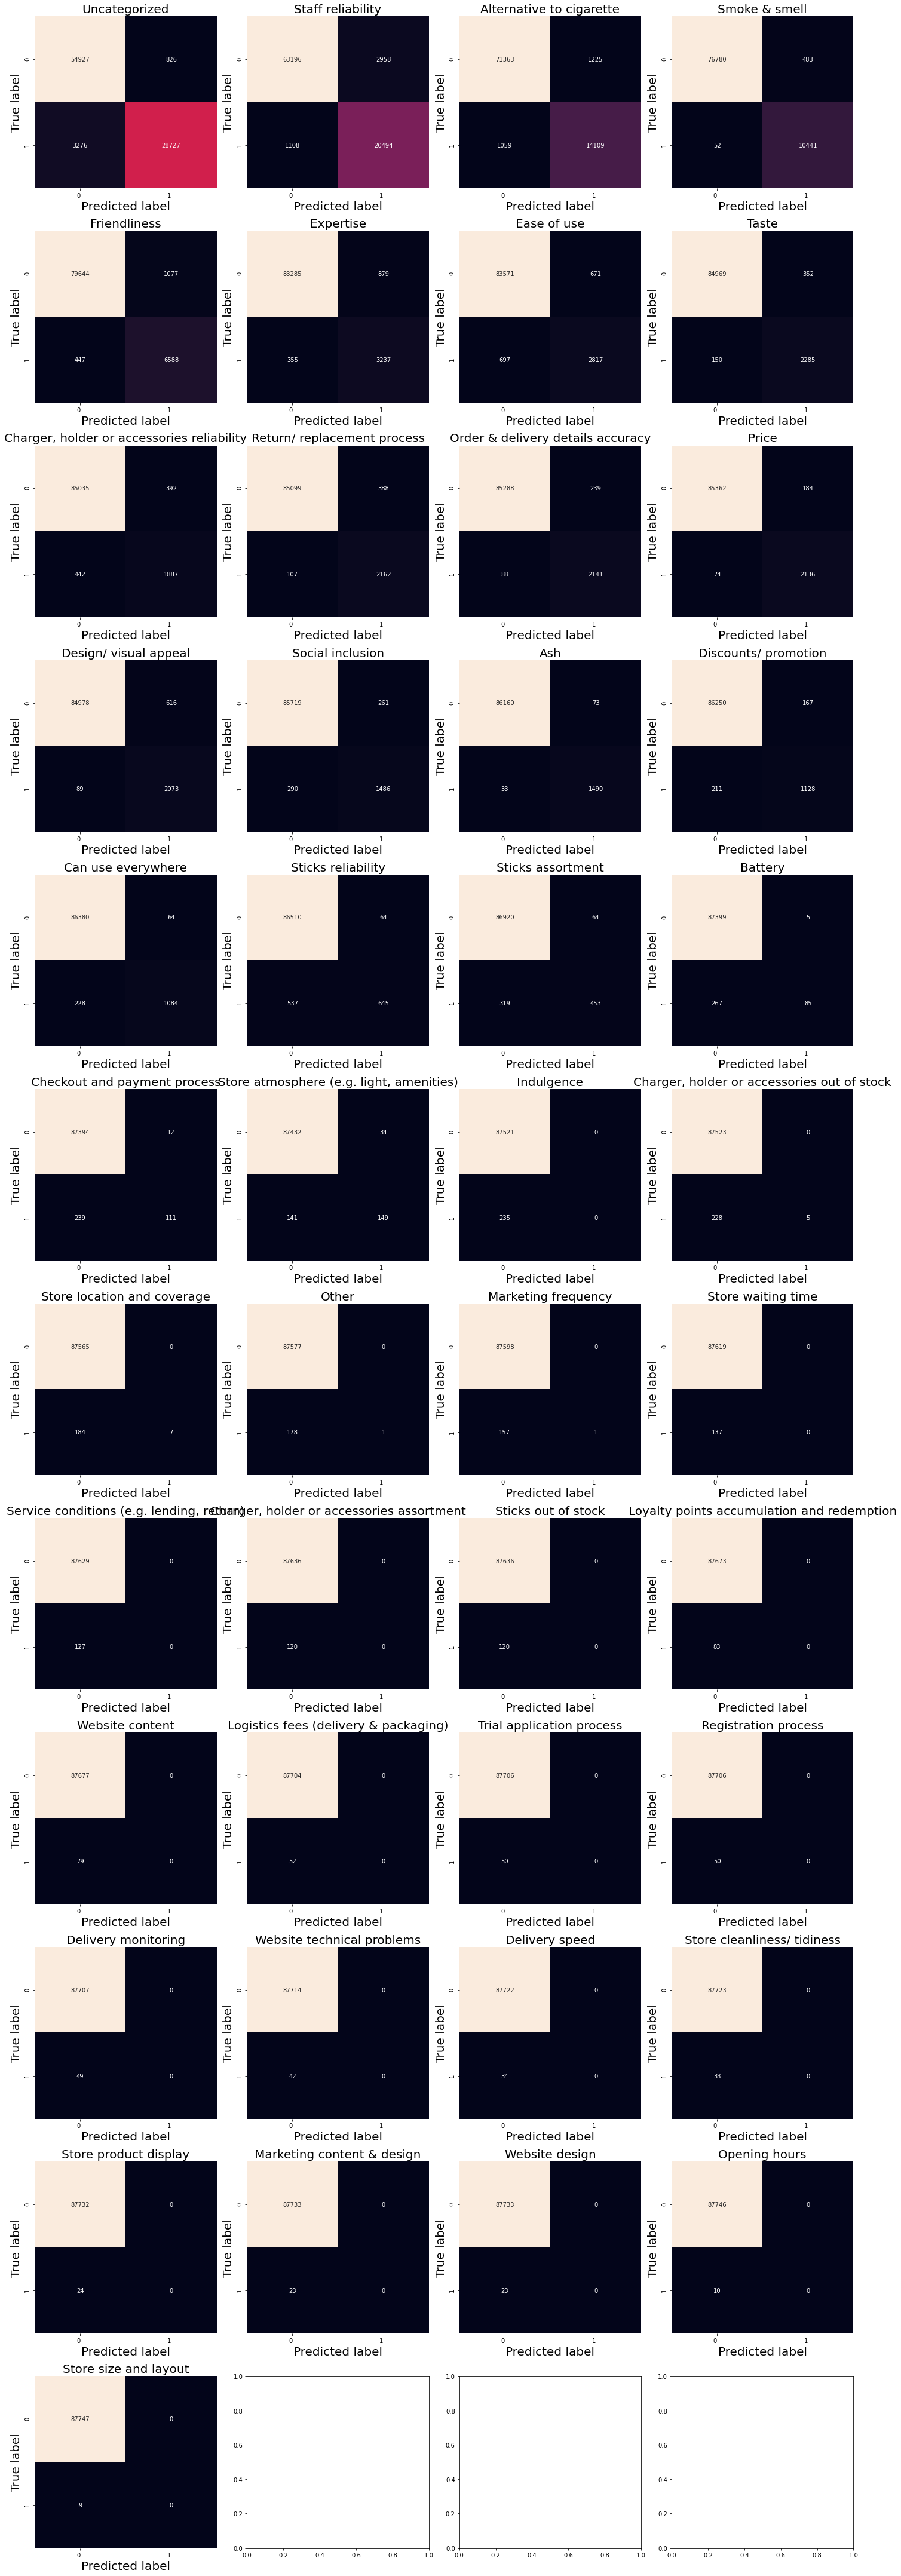

In [18]:
y_train, y_train_preds, mlb  = get_preds('train', verbose = True)
y_valid, y_valid_preds, _  = get_preds('valid', verbose = True, mlb = mlb)
y_test, y_test_preds, _  = get_preds('test', verbose = True, mlb = mlb)

train_acc, train_acc_class, train_hamm, train_f1_score, train_f1_score_class, train_roc_auc, train_roc_auc_class = \
  calculate_metrics(y_train, y_train_preds, len(mlb.classes_), micro = True)

valid_acc, valid_acc_class, valid_hamm, valid_f1_score, valid_f1_score_class, valid_roc_auc, valid_roc_auc_class = \
  calculate_metrics(y_valid, y_valid_preds, len(mlb.classes_), micro = True)

test_acc, test_acc_class, test_hamm, test_f1_score, test_f1_score_class, test_roc_auc, test_roc_auc_class = \
  calculate_metrics(y_test, y_test_preds, len(mlb.classes_), micro = True)

print("Train:        Accuracy: %.5f, F1 score: %.5f, Hamming Loss: %.5f, ROC-AUC: %.5f" % \
      (train_acc, train_f1_score, train_hamm, train_roc_auc))
print("Validation:   Accuracy: %.5f, F1 score: %.5f, Hamming Loss: %.5f, ROC-AUC: %.5f" % \
      (valid_acc, valid_f1_score, valid_hamm, valid_roc_auc))
print("Test:         Accuracy: %.5f, F1 score: %.5f, Hamming Loss: %.5f, ROC-AUC: %.5f" % \
      (test_acc, test_f1_score, test_hamm, test_roc_auc))

print_classes_metrics(train_acc_class, train_f1_score_class, train_roc_auc_class, y_train, 
                      valid_acc_class, valid_f1_score_class, valid_roc_auc_class, y_valid,
                      test_acc_class, test_f1_score_class, test_roc_auc_class, y_test,
                      mlb.classes_)
plot_cm(y_train, y_train_preds, mlb.classes_)

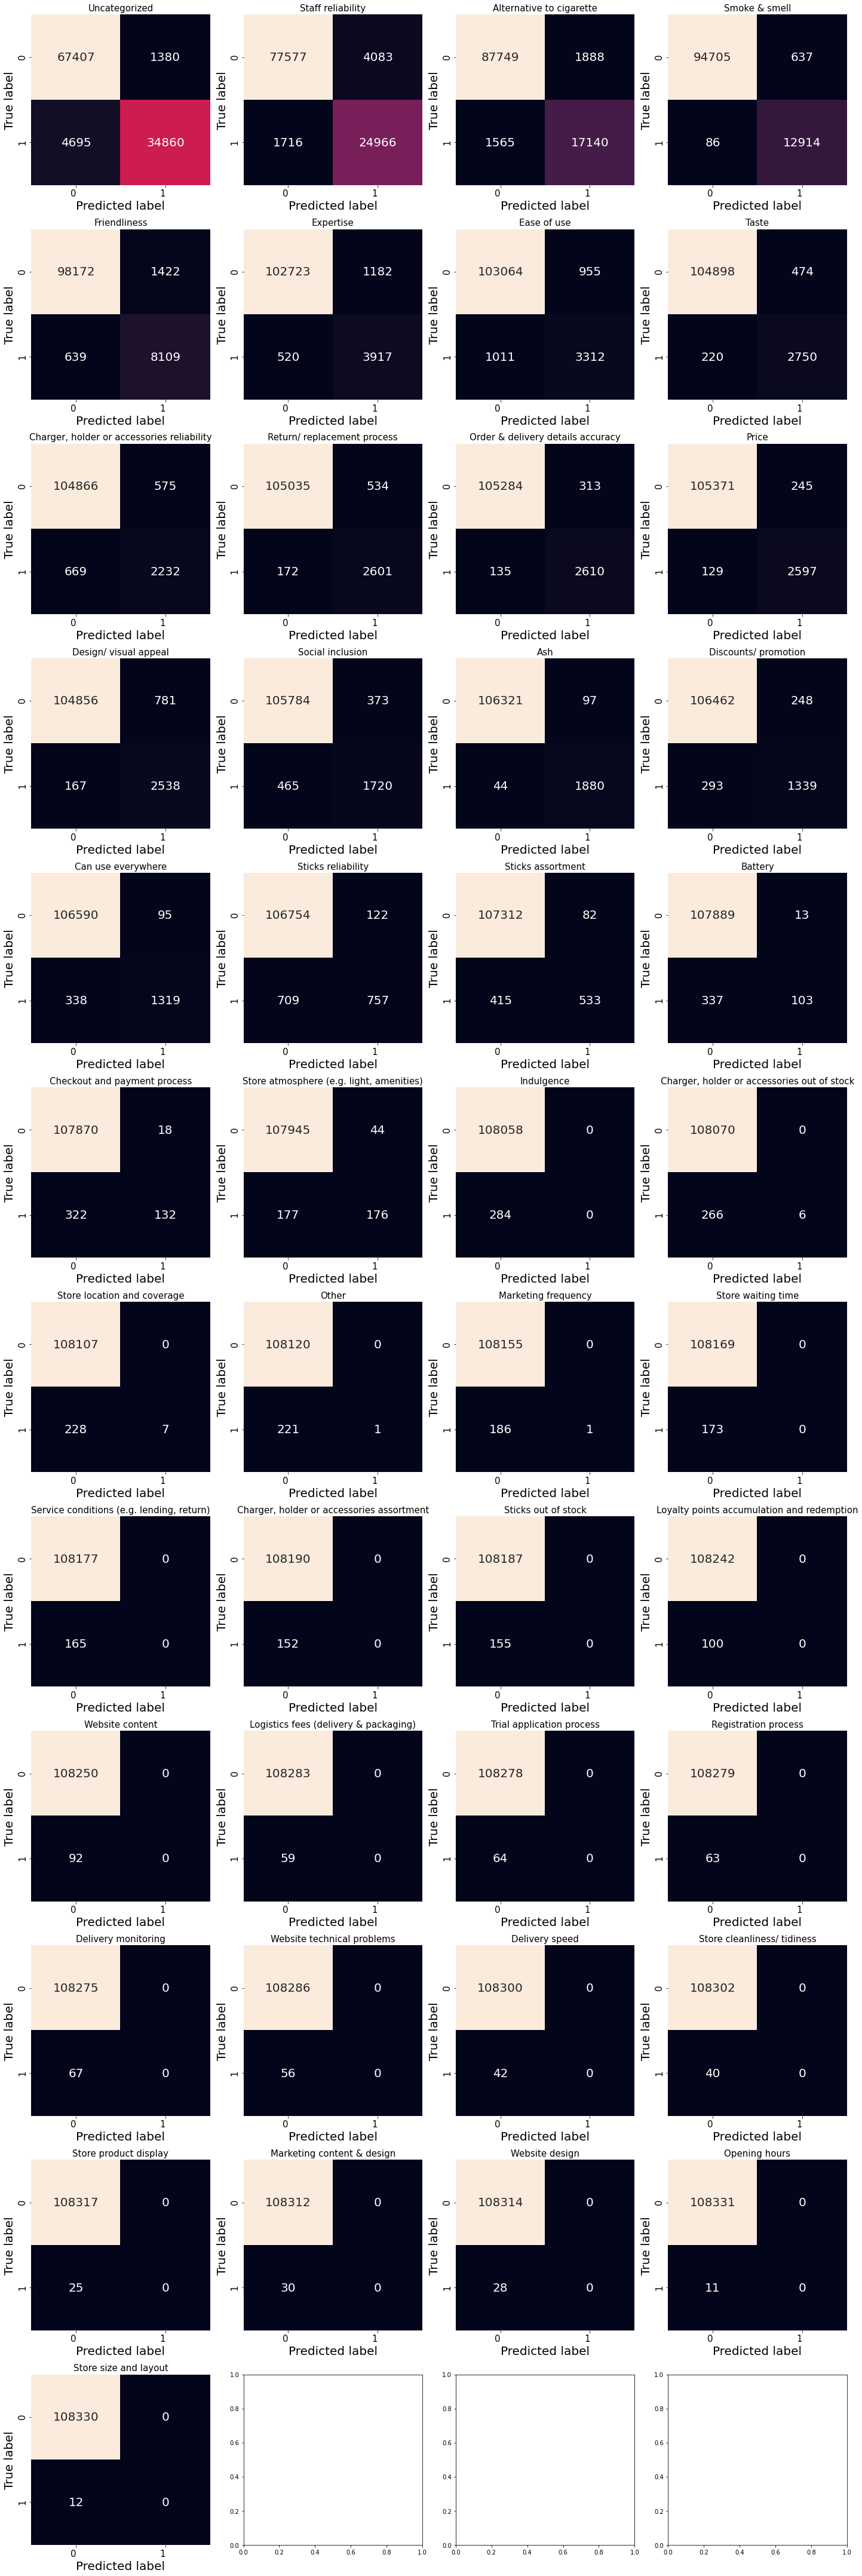

In [111]:
plot_cm(np.concatenate([y_train, y_valid, y_test]), 
        np.concatenate([y_train_preds, y_valid_preds, y_test_preds]), 
        mlb.classes_)

### Results with optimal probability threshold

Calculating optimal threshold



Train:        Accuracy: 0.00000, F1 score: 0.90265, Hamming Loss: 0.00572, ROC-AUC: 0.99274
Validation:   Accuracy: 0.70075, F1 score: 0.82112, Hamming Loss: 0.01052, ROC-AUC: 0.97403
Test:         Accuracy: 0.69479, F1 score: 0.81693, Hamming Loss: 0.01073, ROC-AUC: 0.97198
                                             Class                   Accuracy        F1 score         ROC-AUC            Size
                                     Uncategorized Train             0.955764        0.952273        0.989532           32003
                                                   Validation        0.903292        0.895927        0.960937            3575
                                                   Test              0.899677        0.891550        0.956388            3977
                                 Staff reliability Train             0.955878        0.940557        0.989784           21602
                                                   Validation        0.917855        0.888868

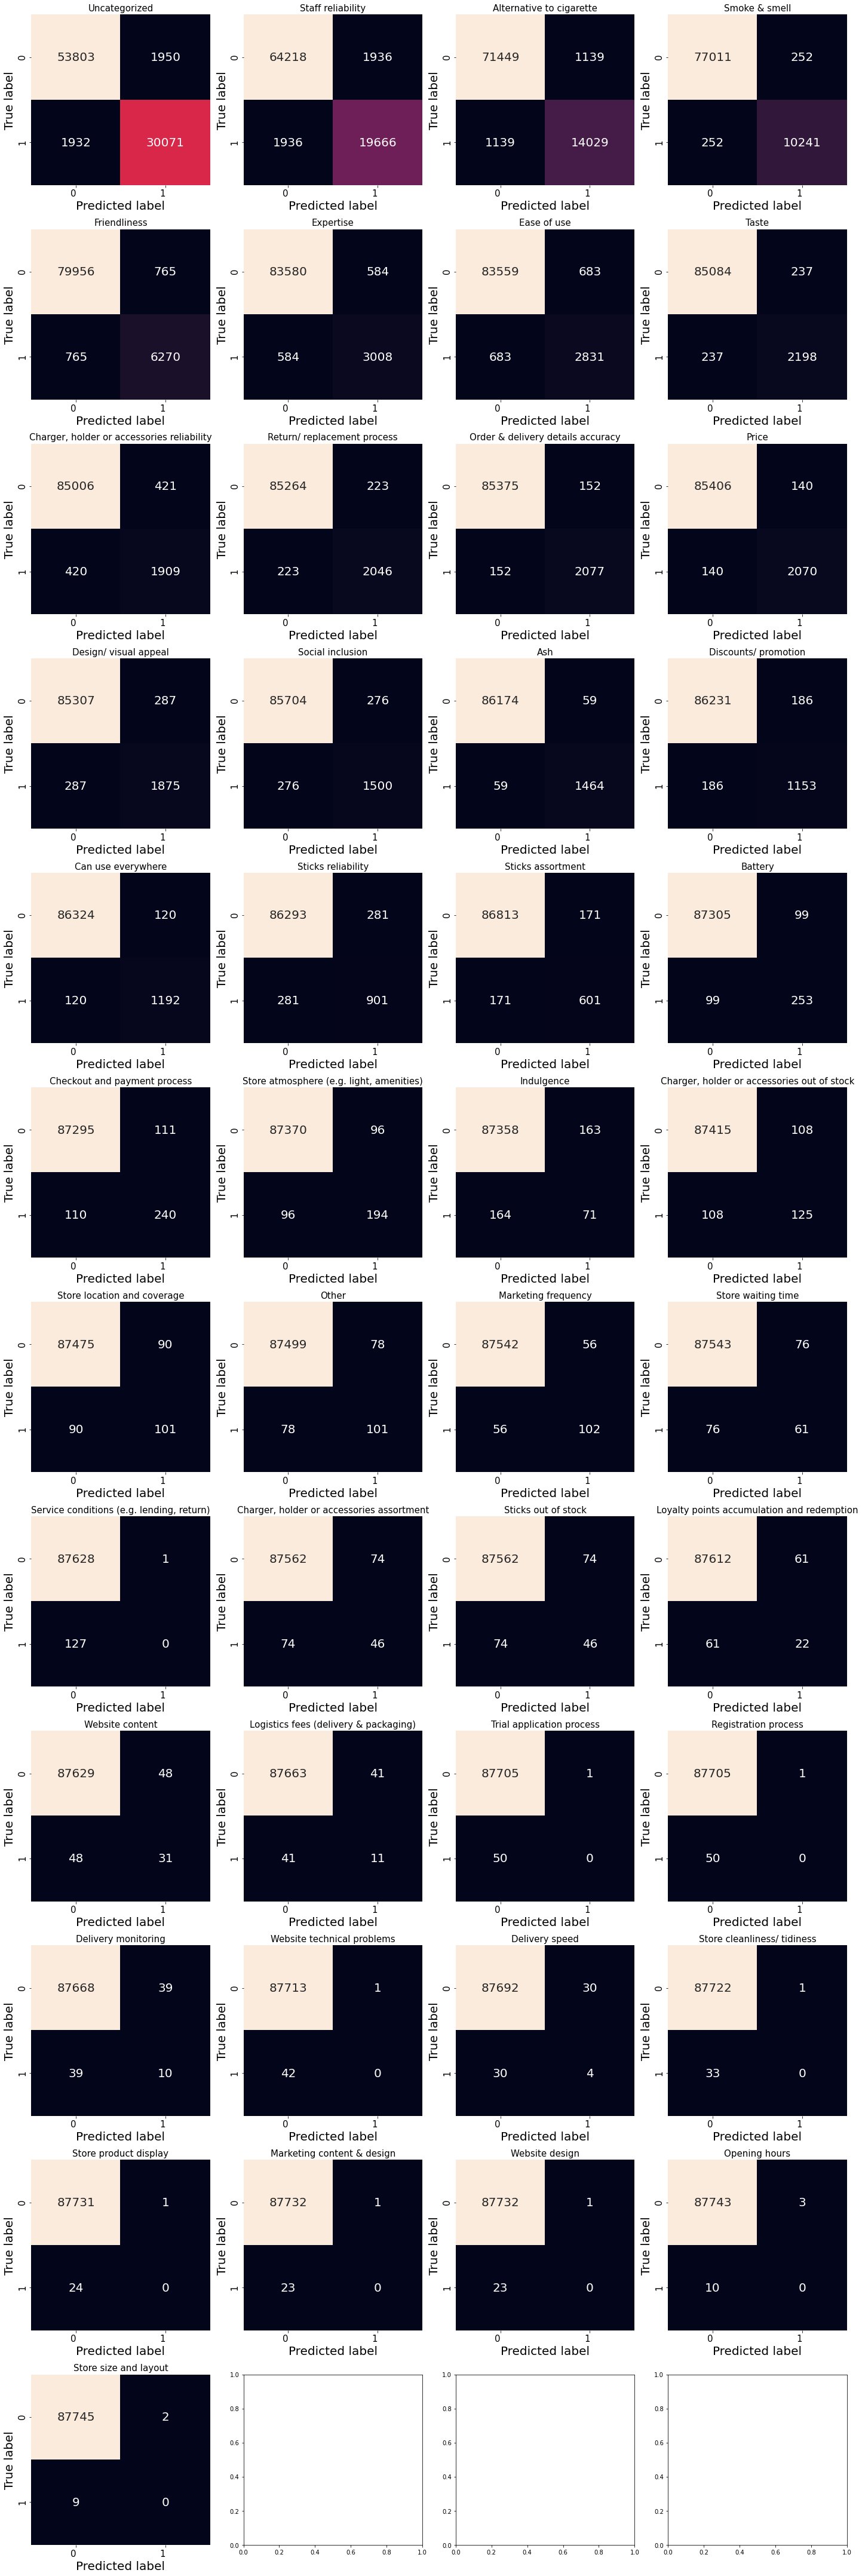

In [112]:
ts = optimal_threshold(y_train, y_train_preds, len(mlb.classes_), verbose = True)

train_acc_ts, train_acc_class_ts, train_hamm_ts, train_f1_score_ts, train_f1_score_class_ts, train_roc_auc_ts, train_roc_auc_class_ts = \
  calculate_metrics(y_train, y_train_preds, len(mlb.classes_), micro = True, ts = ts)

valid_acc_ts, valid_acc_class_ts, valid_hamm_ts, valid_f1_score_ts, valid_f1_score_class_ts, valid_roc_auc_ts, valid_roc_auc_class_ts = \
  calculate_metrics(y_valid, y_valid_preds, len(mlb.classes_), micro = True, ts = ts)

test_acc_ts, test_acc_class_ts, test_hamm_ts, test_f1_score_ts, test_f1_score_class_ts, test_roc_auc_ts, test_roc_auc_class_ts = \
  calculate_metrics(y_test, y_test_preds, len(mlb.classes_), micro = True, ts = ts)

print("Train:        Accuracy: %.5f, F1 score: %.5f, Hamming Loss: %.5f, ROC-AUC: %.5f" % \
      (train_acc_ts, train_f1_score_ts, train_hamm_ts, train_roc_auc_ts))
print("Validation:   Accuracy: %.5f, F1 score: %.5f, Hamming Loss: %.5f, ROC-AUC: %.5f" % \
      (valid_acc_ts, valid_f1_score_ts, valid_hamm_ts, valid_roc_auc_ts))
print("Test:         Accuracy: %.5f, F1 score: %.5f, Hamming Loss: %.5f, ROC-AUC: %.5f" % \
      (test_acc_ts, test_f1_score_ts, test_hamm_ts, test_roc_auc_ts))

print_classes_metrics(train_acc_class_ts, train_f1_score_class_ts, train_roc_auc_class_ts, y_train, 
                      valid_acc_class_ts, valid_f1_score_class_ts, valid_roc_auc_class_ts, y_valid,
                      test_acc_class_ts, test_f1_score_class_ts, test_roc_auc_class_ts, y_test,
                      mlb.classes_)
plot_cm(y_train, y_train_preds, mlb.classes_, ts = ts)

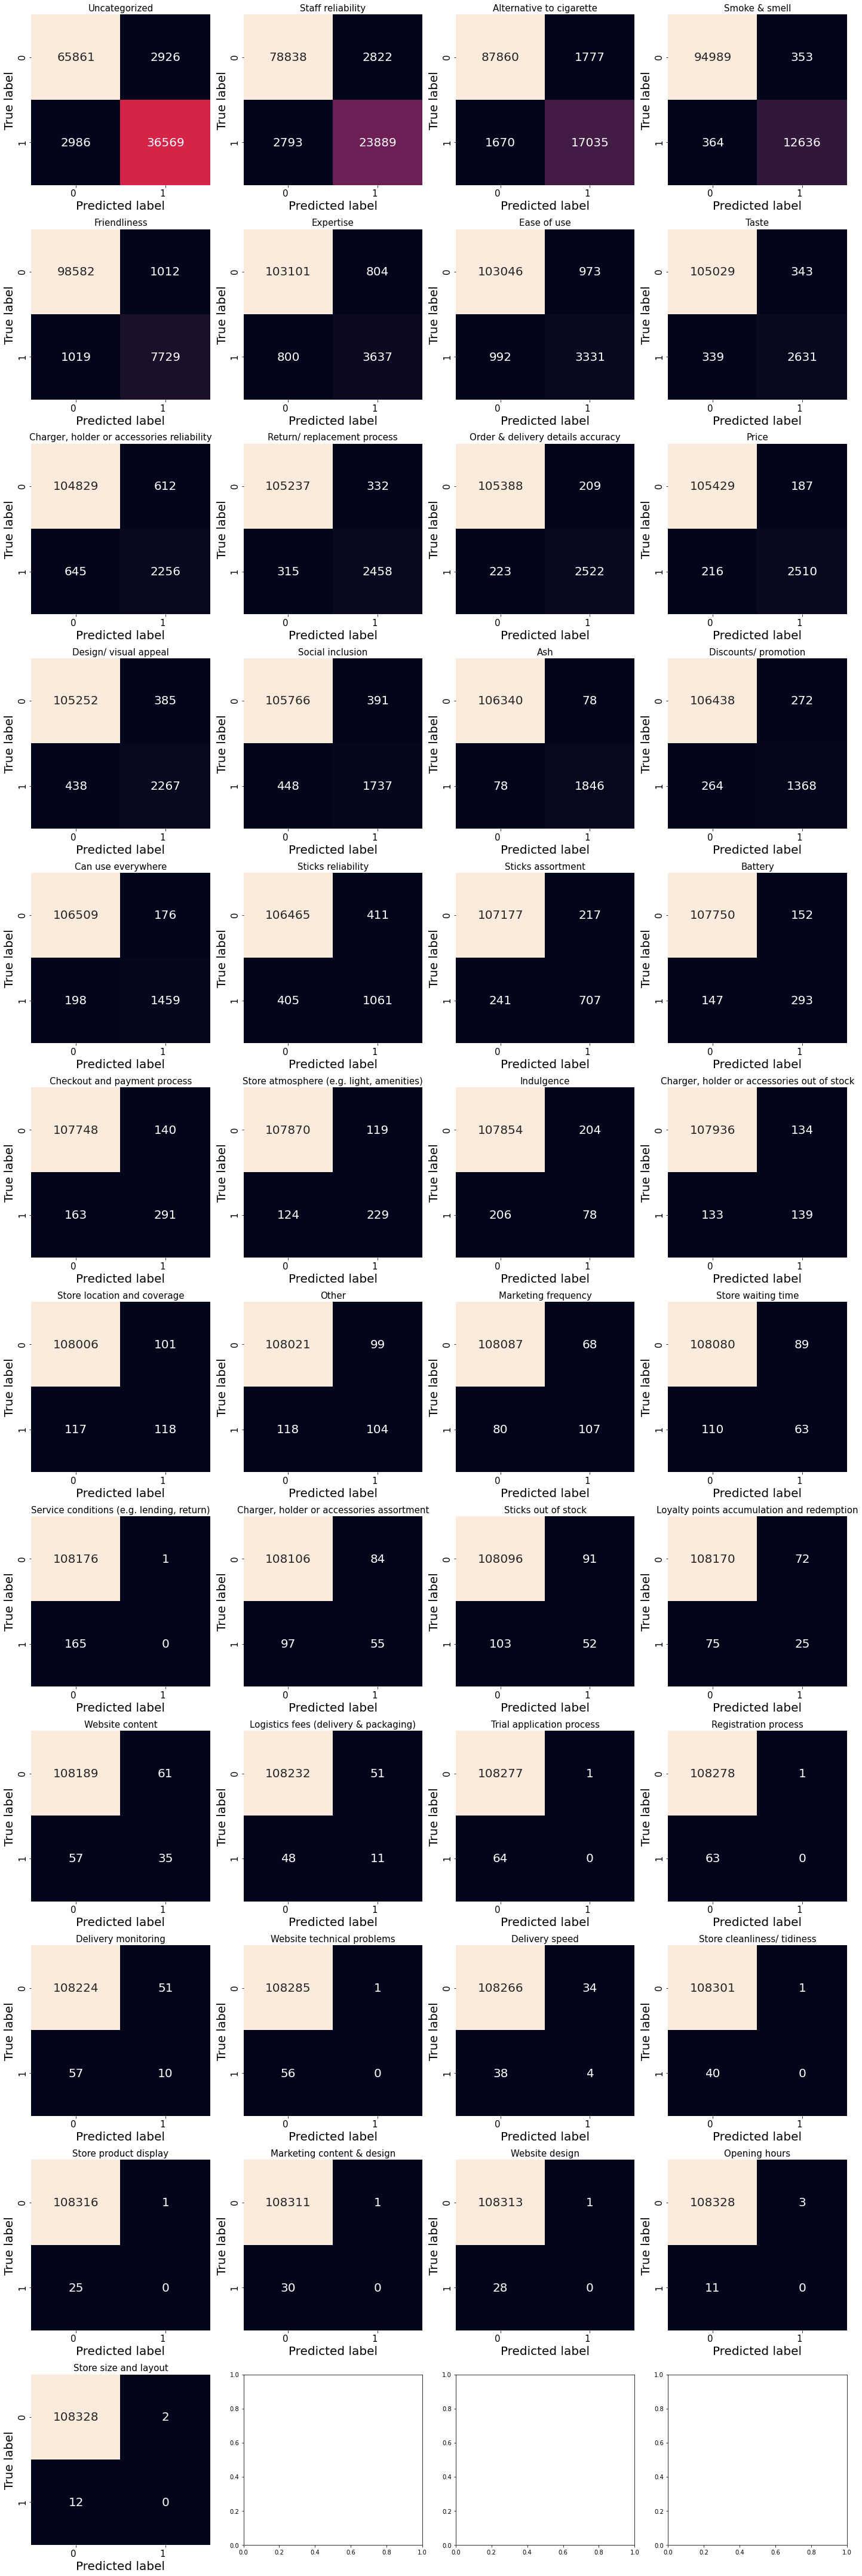

In [113]:
plot_cm(np.concatenate([y_train, y_valid, y_test]), 
        np.concatenate([y_train_preds, y_valid_preds, y_test_preds]), 
        mlb.classes_, ts = ts)

Save thresholds array

In [21]:
np.save(PATH_SAVE + r'/ts.npy', ts)